In [1]:
# Load required modules
from datetime import date
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

In [2]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
files = [f'{base_url}sst.day.mean.{year}.v2.nc' for year in range(1981, 2021)]
#files
#https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc.html

In [3]:
%%time
data = xr.open_mfdataset(files)

CPU times: user 478 ms, sys: 59.6 ms, total: 538 ms
Wall time: 3.35 s


# Case study #4: 2017 Tasman

#### Plot a lat and lon 
In this case, we will visualize a point from the Tasman Sea (TAS; 148.36 ∘ E, 42.48 ∘ S) over the 1982 to 2014 period.

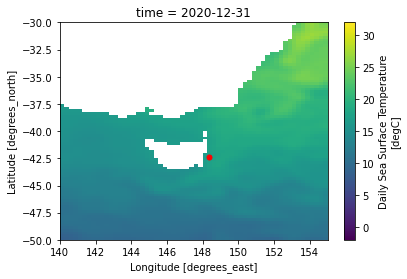

In [4]:
fig, ax = plt.subplots(1,1)
dummy = data.sst.sel(lon = 148.36, lat =-42.48, method='nearest')[0]
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_ylim(-50,-30)
ax.set_xlim(140,155);

#### Load the data
Daily time series of SST (from the same point used above) remotely-sensed from the AVHRR satellite platform

Uncomment below to run full function but see below to save time

In [5]:
#%%time
#tas_ds = data.sst.sel(lon = 148.36, lat = -42.48, 
             #method='nearest').sel(time = slice("1982-01-01","2020-12-31")).load()

In [6]:
#tas_ds.to_netcdf('tas_ds.nc')

In [7]:
#Uncomment line below to start from here
tas_ds=xr.open_dataset('tas_ds.nc').sst

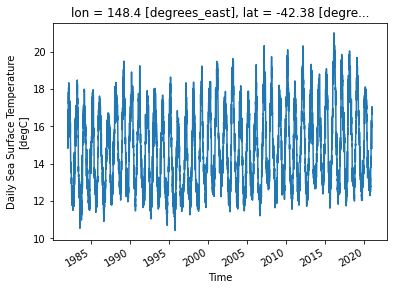

In [8]:
tas_ds.plot()

#### Run MHW detection algorithm
Next we run the MHW detection algorithm which returns the variable mhws, consisting of the detected MHWs, and clim, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:

In [9]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2020,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [10]:
# Detect MHW events
mhws_case4, clim_case4 = mhw.detect(t, tas_ds.values, climatologyPeriod=[2015, 2016])

In [11]:
# This algorithm has detected the following number of MHW events:
mhws_case4['n_events']

40

In [12]:
#uncomment the line below to view the duration of each event
#mhws_case4['duration']

In [13]:
#uncomment the line below to view the category of each event
#mhws_case4['category']

##### Let's have a look at some properties associated with the event that has the largest maximum intensity

In [14]:
ev = np.argmax(mhws_case4['intensity_max']) # largest event
print ('Maximum intensity:', mhws_case4['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case4['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case4['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case4['duration'][ev], 'days')
print ('Start date:', mhws_case4['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case4['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 2.9790757702242914 deg. C
Average intensity: 2.230957138922904 deg. C
Cumulative intensity: 31.233399944920656 deg. C-days
Duration: 14 days
Start date: 22 November 2017
End date: 05 December 2017


##### Let's plot the SST time series over the full record and also have a closer look at the identified MHW event:

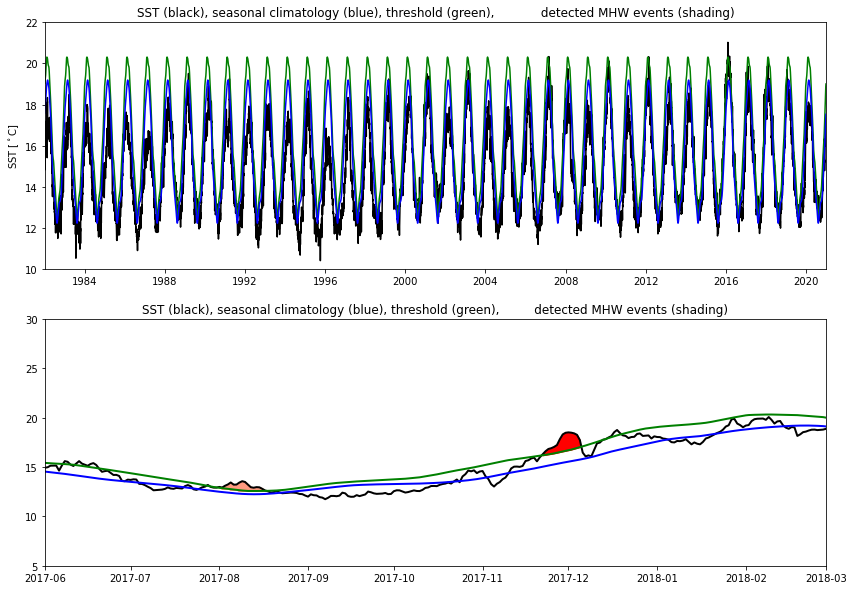

In [15]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, tas_ds, 'k-')
plt.plot(dates, clim_case4['thresh'], 'g-')
plt.plot(dates, clim_case4['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
           detected MHW events (shading)')
plt.ylim(tas_ds.min()-0.5, tas_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(dates[0],dates[-1])
plt.ylim(10,22);

# second plot
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case4['time_start'][ev-1])[0][0]
    t2 = np.where(t==mhws_case4['time_end'][ev-1])[0][0]
    plt.fill_between(dates[t1:t2+1], tas_ds[t1:t2+1], clim_case4['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2012 NWA event) and shade accordingly
t1 = np.where(t==mhws_case4['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case4['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], tas_ds[t1:t2+1], clim_case4['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, tas_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case4['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case4['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
        detected MHW events (shading)')
plt.xlim(date(2017,6,1), date(2018,3,1))
plt.ylim(5,30);

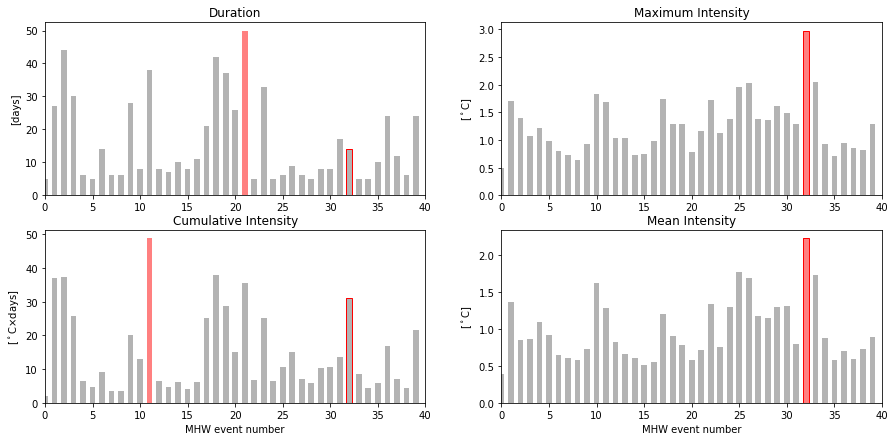

In [16]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case4['duration'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case4['intensity_max'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case4['intensity_mean'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case4['intensity_cumulative'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

In [17]:
# rank this MHW event
rank, returnPeriod = mhw.rank(t, mhws_case4)
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2017 Tasman Sea event is ranked number 15 by duration
The 2017 Tasman Sea event is ranked number 1 by maximum intensity
The 2017 Tasman Sea event is ranked number 1 by mean intensity
The 2017 Tasman Sea event is ranked number 6 by cumulative intensity
